# Web Scraping - Indeed


In [1]:
# 所有要用的包都放这里
import pandas as pd
from urllib import parse
import re
import requests
import itertools
from bs4 import BeautifulSoup
import itertools
import time
import os
from google.colab import drive
import numpy as np
import plotly.express as px

!pip install nltk==3.6.7 --upgrade
!pip install spacy==3.2.1 --upgrade
!python -m spacy download en_core_web_sm-3.2.0 --direct
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from collections import Counter

import gensim
from gensim import corpora
from gensim.test.utils import datapath
from pandas.io.parsers.readers import read_csv

     |████████████████████████████████| 660 kB 44.7 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.9.1
    Uninstalling pydantic-1.9.1:
      Successfully uninstalled pydantic-1.9.1
  Attempting uninstall: thinc
    Found existing installation: thinc 8.1.0
    Uninstalling thinc-8.1.0:
      Successfully uninstalled thinc-8.1.0
  Attempting uninstall: spacy
    Found existing installation: spacy 3.4.1
    Uninstalling spacy-3.4.1:
      Successfully uninstalled spacy-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.4.0 requires spacy<3.5.0,>=3.4.0, but you have spacy 3.2.1 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.9 MB 5.1 MB/s 
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 3.4.0
    Uninstalling en-core-web-sm-3.4.0:
      Successfully uninstalled en-core-web-sm-3.4.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# 思路：
### 爬数据方面
1. 把所有的岗位的，前30页的，job url拿出来
2. 对job url里头提取具体的5个方面的信息：
    比如说
    1. 公司名字
    2. 岗位名称
    3. 职位描述
    4. posted day	
    5. views

### 清理数据方面：
 去重，去空，找替代值
 
### 分析数据方面：

1. 近一个月急招公司
2. 就业市场对不同层次人才的要求
(e.g., entry-level, senior-level, staff level, principal level, etc.) 
4. DA, UX, SDE的十大技能
(SQL,tableau,python………)
5. 最受欢迎的10家雇主
6. 哪个职位很难找到工作


# 1. 把所有的岗位的，前10页的，job url拿出来

In [ ]:
#某个岗位，某个地址，任意一页的 url
def get_indeed_search_url(q, l, pagenum):
    if pagenum<=0:
        pagenum=1
    baseurl = 'https://www.indeed.com/jobs?'
    paramstr = parse.urlencode( { 'q': q, 'l': l, 'start': (pagenum-1)*10 } )
    return baseurl + paramstr
#我要10页的，每页里头所有的job(每页有15个job放出来)的url  
#最后记得改这个页数，莫忘了 
def get_each_job_url(q,l):
  mainpage_url = []
  j=[]
  for p in range(1,11):
    a = get_indeed_search_url(q, l, p)
    mainpage_url.append(a)

  headers = {
      "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.83 Safari/537.36",
      "Accept-Language": "en-US,en;q=0.9,zh-CN;q=0.8,zh;q=0.7,fi;q=0.6,zh-TW;q=0.5,ja;q=0.4,es;q=0.3"
  }
  for i in range(len(mainpage_url)):

    response = requests.get(mainpage_url[i], headers=headers)
    time.sleep(15)
    keys = re.findall("jobKeysWithInfo\['(.+?)'\] = true;", response.text)
    for k in keys:
      job_urls = 'https://www.indeed.com/viewjob?jk='+k 
      if len(job_urls)>0:
        j.append(job_urls)
  return j

In [ ]:
#'software engineer','seattle' 5页的所有job
# 例子
#get_each_job_url('software engineer','seattle')

In [ ]:
#设置我们的searchlist，把我们需要的岗位，和location都放进去
#太多了 跑太慢了，我注释掉了一些
searchjoblist = [
'Front-end web development Engineer',
'Back-end web development Engineer',
'Full-stack development Engineer',
'Software Development Engineer',
'Data Analyst',
'Data engineer',
'Data scientist',
'UX Designer',
'UX programmer'
]
searchlocationlist = [
 'Chicago',
 'NY',
 'San Francisco'                     
]

In [ ]:
#把上面两个searchlist排列组合
res = list(itertools.product(searchjoblist, searchlocationlist))
res

[('Front-end web development Engineer', 'Chicago'),
 ('Front-end web development Engineer', 'NY'),
 ('Front-end web development Engineer', 'San Francisco'),
 ('Back-end web development Engineer', 'Chicago'),
 ('Back-end web development Engineer', 'NY'),
 ('Back-end web development Engineer', 'San Francisco'),
 ('Full-stack development Engineer', 'Chicago'),
 ('Full-stack development Engineer', 'NY'),
 ('Full-stack development Engineer', 'San Francisco'),
 ('Software Development Engineer', 'Chicago'),
 ('Software Development Engineer', 'NY'),
 ('Software Development Engineer', 'San Francisco'),
 ('Data Analyst', 'Chicago'),
 ('Data Analyst', 'NY'),
 ('Data Analyst', 'San Francisco'),
 ('Data engineer', 'Chicago'),
 ('Data engineer', 'NY'),
 ('Data engineer', 'San Francisco'),
 ('Data scientist', 'Chicago'),
 ('Data scientist', 'NY'),
 ('Data scientist', 'San Francisco'),
 ('UX Designer', 'Chicago'),
 ('UX Designer', 'NY'),
 ('UX Designer', 'San Francisco'),
 ('UX programmer', 'Chicago')

In [ ]:
#职位
print(res[0][0])
#城市
print(res[0][1])
#把这两分别代入到中去 # get_each_job_url('software engineer','seattle')

Front-end web development Engineer
Chicago


In [ ]:
#以上searchlist里头的所有的job

search = pd.DataFrame()
for i in range(len(res)):
  q= res[i][0]
  l= res[i][1]
  for link in get_each_job_url(q,l):
    new_row = {'keyword':q,'location':l,'joblink':link}
    search = search.append(new_row, ignore_index=True)

search



,keyword,location,joblink
0,Front-end web development Engineer,Chicago,https://www.indeed.com/viewjob?jk=64e0a5fbf103...
1,Front-end web development Engineer,Chicago,https://www.indeed.com/viewjob?jk=bb475fa2a09b...
2,Front-end web development Engineer,Chicago,https://www.indeed.com/viewjob?jk=4acf51e325e2...
3,Front-end web development Engineer,Chicago,https://www.indeed.com/viewjob?jk=fbe5b541f511...
4,Front-end web development Engineer,Chicago,https://www.indeed.com/viewjob?jk=c34687dde26c...
...,...,...,...
865,UX Designer,NY,https://www.indeed.com/viewjob?jk=d9c9288281d4...
866,UX Designer,NY,https://www.indeed.com/viewjob?jk=582f065e540d...
867,UX Designer,NY,https://www.indeed.com/viewjob?jk=727b114db7f0...
868,UX Designer,NY,https://www.indeed.com/viewjob?jk=8954eb5109b1...


# 2. 对job url里头提取具体的5个方面的信息：

2.1 先用beautifulsoup 把我们的某一job页面的资料全爬下来

In [ ]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9,zh-CN;q=0.8,zh;q=0.7,fi;q=0.6,zh-TW;q=0.5,ja;q=0.4,es;q=0.3"
}

In [ ]:
from contextlib import nullcontext
#从网页扒出具体信息
def extrct_info(url):
  positon = ""
  company = ""
  reviews = ""
  discription = ""
  visa = ""
  post_day = ""
  #Intepret the url with beautiful soup

  response = requests.get(url = url, headers=headers)
  time.sleep(15)
  soup = BeautifulSoup(response.text, 'html.parser')
  
  #Extract job title
  matches = soup.find_all('div')
  if(len(matches)>=1):
    position = matches[0].find('h1').text

  #扒出company和reviews - 用于popular reviews分析
  matches = soup.find_all('div', attrs={'class':'icl-u-lg-mr--sm icl-u-xs-mr--xs'})
  if(len(matches)>=1):
    company = matches[1].find('a').text.replace("\n","")
    
  matches = soup.find_all('div', attrs={'class':'icl-Ratings-count'})
  if(len(matches)>=1):
    reviews = matches[0].text.replace("\n","")
  

  # 扒出job discripton - 用于skill set分析/level分析
  matches = soup.find_all('div', attrs={'class':'jobsearch-jobDescriptionText'})
  target = matches[0]
  level = 0;
  if(len(matches)>=1):
    while(1):
      target = target.find_next('h2',{'class':'jobSectionHeader'})
      # print(target)
      if target is None and (level == 0):
        target = soup.find('h2',text = 'Full Job Description')
        # print(target)
        if target is not None:
          for sib in target.find_next_siblings():
            if sib.name=="h2":
              break
            else:
              discription += sib.text.replace("\n","")
        break

      elif target is None:
        break

      else:
        for sib in target.find_next_siblings():
          if sib.name=="h2":
            break
          else:
            discription += sib.text.replace("\n","")
        level = level + 1
  
  #   discription = matches[0].find('b').find_next('b').find_next('p').find_next('p').find_next('p').text
  #   discription = discription + matches[0].find('ul').text
  #   discription = discription + matches[0].find('ul').find_next('ul').text
  #   discription = discription + matches[0].find('ul').find_next('ul').find_next('ul').text

  # #扒出visa - 用于visa分析
  #   match = matches[0].find('ul').find_next('ul').find_next('ul').find_next('p')
  #   if(match is not None):
  #     visa = str(matches[0].find('ul').find_next('ul').find_next('ul').find_next('p').next_sibling).strip()

  #扒出post day - 用于New post of jobs within a month分析
  matches = soup.find_all('div', attrs={'class':'jobsearch-HiringInsights-root jobsearch-HiringInsights-root--bottomborder'})
  if(len(matches)>0):
    post_day = matches[0].find('p').text.replace("\n","")

  #扒出来的存在dict里面
  info = {"position":position,"company": company,"reviews" : reviews, "discription" : discription, "visa": visa, "post_day" : post_day, "job_link":url}
  return info

In [ ]:
#print(extrct_info("https://www.indeed.com/viewjob?jk=55e38720ceb8f380"))

In [ ]:
list1 = []
# for i in range(len(d['joblink'])+1):
iterate = 500 #一次放进去多少个link
for url in search['joblink']:
    if iterate == 0: break
    try:
        list1.append(extrct_info(url))
        
    except Exception as e:
        list1.append({'error id': 1})
        pass

    iterate = iterate -1
    continue


In [ ]:
#这个是根据每一个joblink爬出来的每个工作内容
ejob = pd.DataFrame(list1,columns = ['position','company','discription','post_day','reviews','job_link','error id'])

ejob


,position,company,discription,post_day,reviews,job_link,error id
0,Senior Front End Engineer - Marketing Web,Glassdoor,Why Glassdoor? Our mission is to help people e...,Posted 24 days ago,47 reviews,https://www.indeed.com/viewjob?jk=64e0a5fbf103...,NaN
1,"Front-End Engineer (FEE), Amazon Ads",Amazon.com Services LLC,Professional non-internship experience with f...,Posted 6 days ago,"81,599 reviews",https://www.indeed.com/viewjob?jk=bb475fa2a09b...,NaN
2,"Senior Software Engineer, Front End",Google,Google's software engineers develop the next-...,Posted 30+ days ago,"4,083 reviews",https://www.indeed.com/viewjob?jk=4acf51e325e2...,NaN
3,Front End Developer,Dermacare,Dermacare LLC (DBA BlueChew) is on a mission t...,Hiring 1 candidate for this role,,https://www.indeed.com/viewjob?jk=fbe5b541f511...,NaN
4,Software Development Engineer II,American Express Global Business Travel,Software Development Engineer II The Ege...,Posted 30+ days ago,"8,371 reviews",https://www.indeed.com/viewjob?jk=c34687dde26c...,NaN
5,Front-End Software Engineer,SimBioSys,SimBioSys is seeking a Front-End Software Engi...,Employer reviewed job 9 days ago,,https://www.indeed.com/viewjob?jk=1f18291c9278...,NaN
6,Front End Engineer,CyberCoders,Front End Engineer JOB TITLE: Front End En...,Posted 3 days ago,56 reviews,https://www.indeed.com/viewjob?jk=463d08ead66e...,NaN
7,Senior Front End JS Engineer,"Mastery Logistics Systems, Inc.",,Posted 1 day ago,,https://www.indeed.com/viewjob?jk=dbca417c0eb1...,NaN
8,Front-End Engineer,RevaComm,Front-end Software Engineer Chicago (REMOTE) H...,Posted 30+ days ago,,https://www.indeed.com/viewjob?jk=02e1fa295a99...,NaN
9,Front End Engineer - Remote,Donnelley Financial Solutions,,Posted 16 days ago,90 reviews,https://www.indeed.com/viewjob?jk=d21f1c8c5c1b...,NaN


In [ ]:
#和我们之前的搜到的所有search (含position,location,joblink) 结合在一起，形成新的dataframe
comb = pd.concat([search,ejob],axis = 1,)

In [ ]:
#先存在本地googlelab
from google.colab import drive
drive.mount('/content/drive')
workdir = '/content/drive/MyDrive/875final'
comb.to_excel( os.path.join( workdir, 'Rawdata.xlsx' ), index = False, header=True )

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3. 数据粗处理(去重;去null;填补缺失值，用xxx替代)

In [ ]:
#把咱存好的文件拿出来
from google.colab import drive
drive.mount('/content/drive')
workdir = '/content/drive/MyDrive/875final'

In [ ]:
data = pd.read_excel( os.path.join( workdir, 'Rawdata.xlsx' ), header=0 )
#公司没爬出来的都不要，errorid之前是拿来正确排序的，现在合并了表格也不需要了
data = data.dropna(subset=['company'], inplace = False)
data= data.drop(columns=['error id'])
#对reviews结果处理（去掉"reviews"，将空值用众数代替）
data['reviews'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
data = data.fillna(value = {'reviews':data['reviews'].mode()[0]},inplace= False)
#对post_day结果处理（爬出来不是日期的去掉，把"today"的天数替换成0，把空值替换成众数）
data.loc[data['post_day'].str.contains('Today'),'post_day'] = '0'
data.loc[data['post_day'].str.contains('Hiring'),'post_day'] = 'hi'
data['post_day'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
#visa没想好咋弄

#drop index，重置index
data = data.reset_index(drop=True)

data['position'].value_counts()
data.drop_duplicates()

,position,company,discription,post_day,reviews,job_link
0,Senior Front End Engineer - Marketing Web,Glassdoor,Why Glassdoor? Our mission is to help people e...,24,47,https://www.indeed.com/viewjob?jk=64e0a5fbf103...
1,"Front-End Engineer (FEE), Amazon Ads",Amazon.com Services LLC,Professional non-internship experience with f...,6,81599,https://www.indeed.com/viewjob?jk=bb475fa2a09b...
2,"Senior Software Engineer, Front End",Google,Google's software engineers develop the next-...,30,4083,https://www.indeed.com/viewjob?jk=4acf51e325e2...
3,Front End Developer,Dermacare,Dermacare LLC (DBA BlueChew) is on a mission t...,,8371,https://www.indeed.com/viewjob?jk=fbe5b541f511...
4,Software Development Engineer II,American Express Global Business Travel,Software Development Engineer II The Ege...,30,8371,https://www.indeed.com/viewjob?jk=c34687dde26c...
5,Front-End Software Engineer,SimBioSys,SimBioSys is seeking a Front-End Software Engi...,9,8371,https://www.indeed.com/viewjob?jk=1f18291c9278...
6,Front End Engineer,CyberCoders,Front End Engineer JOB TITLE: Front End En...,3,56,https://www.indeed.com/viewjob?jk=463d08ead66e...
7,Senior Front End JS Engineer,"Mastery Logistics Systems, Inc.",NaN,1,8371,https://www.indeed.com/viewjob?jk=dbca417c0eb1...
8,Front-End Engineer,RevaComm,Front-end Software Engineer Chicago (REMOTE) H...,30,8371,https://www.indeed.com/viewjob?jk=02e1fa295a99...
9,Front End Engineer - Remote,Donnelley Financial Solutions,NaN,16,90,https://www.indeed.com/viewjob?jk=d21f1c8c5c1b...


In [ ]:
temp = data.isnull().any() #检测列中是否存在空值
print(type(temp))
print(temp)
#现在就差discription的空值还未处理

<class 'pandas.core.series.Series'>
position       False
company        False
discription     True
post_day       False
reviews        False
job_link       False
dtype: bool


In [ ]:
#先存在本地googlelab
from google.colab import drive
drive.mount('/content/drive')
workdir = '/content/drive/MyDrive/875final'
data.to_excel( os.path.join( workdir, 'DATAcleared.xlsx' ), index = False, header=True )

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 4. 具体分析,制图

### 4.1 近一个月急招公司


In [ ]:
ux = pd.read_excel('UXcleared.xlsx')
frontend_dev = pd.read_excel('sdecleared.xlsx')
data_analyst = pd.read_excel('dacleared.xlsx')

In [ ]:
df_lst = [ux, frontend_dev, data_analyst]
df_main = pd.concat(df_lst)

In [ ]:
#上个月发布的职位数量。
employers = df_main[df_main['post_day'] <= 30]
employers = employers['company'].value_counts().reset_index()
top_10_employers = employers[:10]
top_10_employers = top_10_employers.rename(columns={'index': 'Employer', 'company': 'Number of Jobs'})
top_10_employers

,Employer,Number of Jobs
0,Google,24
1,Humanity,16
2,VMware,11
3,"JPMorgan Chase Bank, N.A.",10
4,"Amazon Dev Center U.S., Inc.",10
5,Amex,10
6,Amazon.com Services LLC,9
7,Accenture,8
8,Square,8
9,WALGREENS,7


In [ ]:
fig = px.bar(top_10_employers, x = 'Employer', y = 'Number of Jobs', color = 'Employer')
fig.show()

### 4.2 就业市场对不同层次人才的需求
(e.g., entry-level, senior-level, staff level, principal level, etc.) 


In [ ]:
df_main['position'].unique()
df_main['position'].str.contains('Senior|senior|Sr.|sr.|Sr|sr').value_counts()[True]

246

In [ ]:
df_main['position'].str.contains('Advanced|advanced').value_counts()[True]

2

In [ ]:
df_main['position'].str.contains('Entry|entry').value_counts()[True]

14

In [ ]:
df_main['position'].str.contains('Staff|staff').value_counts()[True]

25

In [ ]:
df_main['position'].str.contains('Junior|junior|Jr.|jr.|Jr|jr').value_counts()[True]

24

In [ ]:
data = {'Position': ['Senior', 'Junior', 'Staff', 'Entry', 'Advanced'], 'Number of Jobs' : [246, 24, 25, 14, 2]}
job_level =pd.DataFrame(data)
job_level

,Position,Number of Jobs
0,Senior,246
1,Junior,24
2,Staff,25
3,Entry,14
4,Advanced,2


In [ ]:
fig = px.line(job_level,  x="Position", y="Number of Jobs",hover_name="Position")
fig.update_traces(line=dict(color="Red", width=3))
fig.show()

### 4.3 DA, UX, SDE的十大技能
(SQL,tableau,python………)


In [ ]:
#函数输入和输出的变量名不一样所以可能计算skill count的代码跑不起来
#但是之前算的skill count的结果我导出来过了 所以直接做了可视化
#职业归类
def CATEGOR(DATASET):

  soft_dev = [
  'Software Development Engineer',
  'Front-end web development Engineer',
  'Back-end web development Engineer',
  'Full-stack development Engineer',                     
  ]
  for i in range(len(soft_dev)):
    DATASET.loc[DATASET['keyword'].str.contains(soft_dev[i]),'category'] = 'sde'

  data_an = [
  'Data Analyst',
  'Data engineer',
  'Data scientist',
  'Business Analyst',
  'Risk Analyst',
  'Business intelligence',
  ]
  for i in range(len(data_an)):
    DATASET.loc[DATASET['keyword'].str.contains(data_an[i]),'category'] = 'da'
    ux_de = [
    'UX Designer',
    'UX programmer'
    ]
  for i in range(len(ux_de)):
    DATASET.loc[DATASET['keyword'].str.contains(ux_de[i]),'category'] = 'ux' 

  DATASET = DATASET.dropna(subset=['discription'], inplace = False)
  DATASET = DATASET.reset_index(drop=True)
  return DATASET

In [ ]:
#所有关键词计数
def entity_count(DATASET):
  TOP100 = Counter(
      [ ent.text for raw in CATEGOR(DATASET)['discription'] for ent in nlp(raw).ents ]
  ).most_common(100)
  return TOP100

sde_count = entity_count(SDE)
da_count = entity_count(DA)
ux_count = entity_count(UX)

In [ ]:
skill_set = {"sde" : ['HTML5','Android','API','EEO','CSS3','CMS','CCC','Turnitin','Agile', 'HCI', 'Chamberlain Group', 'NYSE', 'Java', 'ITF Group','SEO','Java','React','DevOps','TypeScript', 'Typescript','CI','Git', 'EAB', 'HTML5', 'Docker', 'Node.js', 'Redux', 'AccuLynx','Lattice','GraphQL', 'Jest', 'Python', 'PostgreSQL', 'Kafka'],
             "da":['SQL','Excel','Tableau','ETL','SAS','visualisation','BI','EEO','Spark','AI','ECS','OIG','SPSS','CRM','Hive','Machine Learning','Hadoop','SAP'],
              "ux": ['UX','UI','Figma','CSS','CSS3','JavaScript','Javascript','wireframes','VMware','Photoshop','TAS','Adobe Creative Suite','Adobe XD','HTML5','Android','API','EEO','CSS3','CMS','CCC','Turnitin','Agile', 'HCI', 'Chamberlain Group']                     

In [ ]:
#->Get skill set count
def get_skill_set(role,skill_set,DF):
  skill_count = {}
  for keyword in skill_set[role]:
    for word in DF:
      if word[0] == keyword:
        skill_count[word[0]] = word[1]
  return skill_count

sde_skill = get_skill_set("sde",skill_set,sde_count)
da_skill = get_skill_set("da",skill_set,da_count)
ux_skill = get_skill_set("ux",skill_set,ux_count)

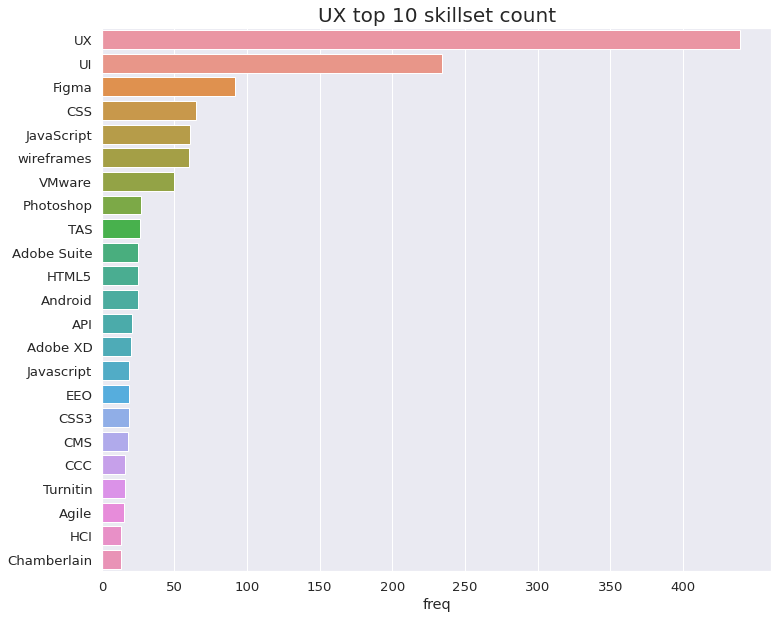

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
#把算出来的结果导出来做图 这样速度快点
skill_sde = {'Java': 84, 'React': 62, 'DevOps': 47, 'TypeScript': 47, 'API': 45, 'CI': 45, 'Git': 43, 'EAB': 33,
             'HTML5': 33, 'Docker': 30, 'CSS3': 29, 'Agile': 27, 'Node.js': 25, 'Redux': 25, 'Typescript': 24,
             'AccuLynx': 20, 'Lattice': 20, 'GraphQL': 19, 'Jest': 17, 'Python': 16, 'Android': 15,
             'PostgreSQL': 15, 'Kafka': 15}

skill_da = {'SQL': 207, 'Excel': 129, 'Tableau': 108, 'ETL': 63, 'SAS': 39, 'BI': 28, 'EEO': 23, 'Spark': 23, 'AI': 22,
            'ECS': 21, 'OIG': 18, 'SPSS': 18, 'CRM': 16, 'Hive': 16, 'ML': 16, 'Hadoop': 15, 'SAP': 15}

skill_ux = {'UX': 439, 'UI': 234, 'Figma': 92, 'CSS': 65, 'JavaScript': 61, 'wireframes': 60, 'VMware': 50,
            'Photoshop': 27, 'TAS': 26, 'Adobe Suite': 25, 'HTML5': 25, 'Android': 25, 'API': 21,
            'Adobe XD': 20, 'Javascript': 19, 'EEO': 19, 'CSS3': 19, 'CMS': 18, 'CCC': 16, 'Turnitin': 16,
            'Agile': 15, 'HCI': 13, 'Chamberlain': 13}


curX, curY = [i for i in skill_ux], [skill_ux[i] for i in skill_ux]
cur_df = pd.DataFrame.from_dict({'skill': curX, 'freq': curY})
sns.set(rc={'figure.figsize': (12, 10)})
sns.set(font_scale=1.2)
g = sns.barplot(data=cur_df, x='freq', y='skill')
g.set(ylabel=None)
plt.title("UX"+' top 10 skillset count', fontsize=20)
plt.xticks([50*i for i in range(9)])
plt.savefig('UX.png', dpi=800)

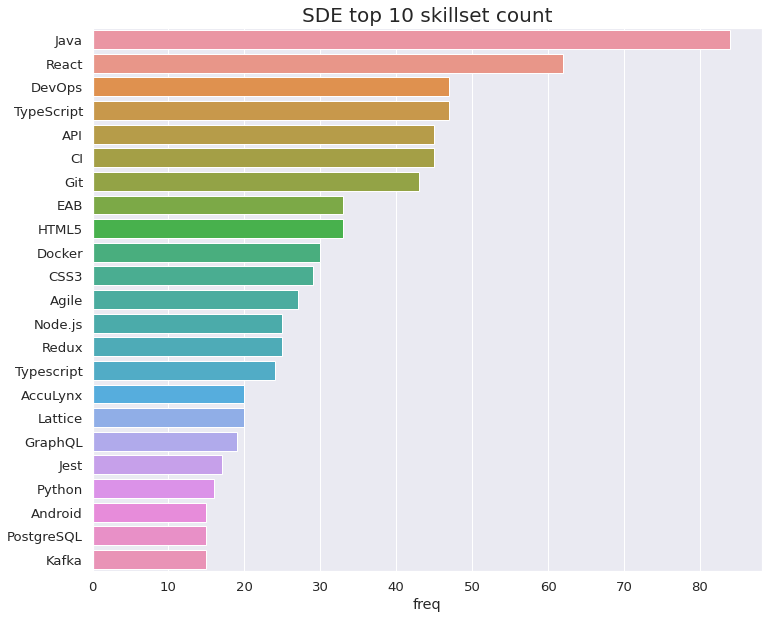

In [ ]:
curX, curY = [i for i in skill_sde], [skill_sde[i] for i in skill_sde]
cur_df = pd.DataFrame.from_dict({'skill': curX, 'freq': curY})
sns.set(rc={'figure.figsize': (12, 10)})
sns.set(font_scale=1.2)
g = sns.barplot(data=cur_df, x='freq', y='skill')
g.set(ylabel=None)
plt.title("SDE"+' top 10 skillset count', fontsize=20)
plt.savefig('SDE.png', dpi=800)

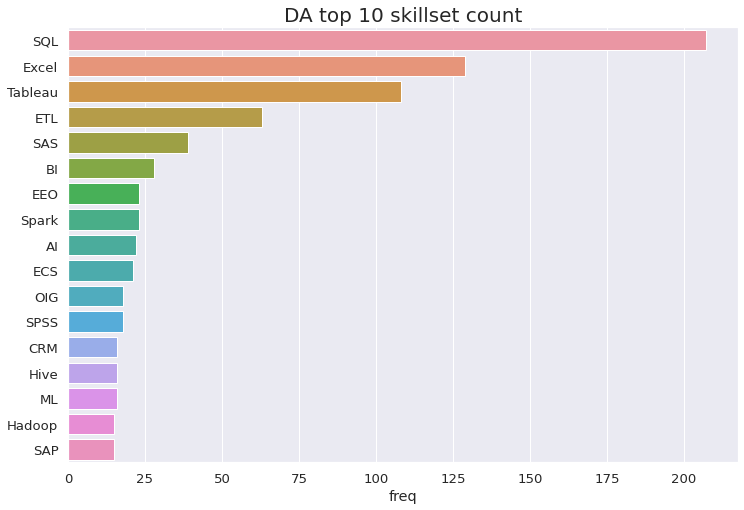

<Figure size 864x576 with 0 Axes>

In [ ]:
curX, curY = [i for i in skill_da], [skill_da[i] for i in skill_da]
cur_df = pd.DataFrame.from_dict({'skill': curX, 'freq': curY})
sns.set(rc={'figure.figsize': (12, 8)})
sns.set(font_scale=1.2)
g = sns.barplot(data=cur_df, x='freq', y='skill')
g.set(ylabel=None)
plt.title("DA"+' top 10 skillset count', fontsize=20)
plt.show()
plt.savefig('DA.png', dpi=800)

### 4.4 最受欢迎的10家雇主

In [ ]:
#按loc看review
reviews = df_main.groupby('location').agg({'reviews': 'sum'}).reset_index()
reviews

,location,reviews
0,Chicago,2197336
1,NY,1635278
2,San Francisco,1083360


In [ ]:
# 对一个公司的总体review。按location分组，画一个sunburn图
comp_reviews = df_main.groupby(['location', 'company']).agg({'reviews': 'sum'}).reset_index()
comp_reviews

,location,company,reviews
0,Chicago,2nd Watch,9
1,Chicago,3Q Digital,17
2,Chicago,"50,000feet",4
3,Chicago,84.51°,5
4,Chicago,AAOS,6
...,...,...,...
957,San Francisco,kW Engineering,5
958,San Francisco,rockset,2
959,San Francisco,sf coin & antique,6
960,San Francisco,super{set} startup studio,2


In [ ]:
fig = px.sunburst(
    comp_reviews,
    path=['location', 'company'], values='reviews',
)
fig.show()

### 4.5 哪个职位很难找到工作

In [ ]:
#上周发布的职位数量。
#职业归类
def CATEGOR(DATASET):

  soft_dev = [
  'Software Development Engineer',
  'Front-end web development Engineer',
  'Back-end web development Engineer',
  'Full-stack development Engineer',                     
  ]
  for i in range(len(soft_dev)):
    DATASET.loc[DATASET['keyword'].str.contains(soft_dev[i]),'category'] = 'sde'

  data_an = [
  'Data Analyst',
  'Data engineer',
  'Data scientist',
  'Business Analyst',
  'Risk Analyst',
  'Business intelligence',
  ]
  for i in range(len(data_an)):
    DATASET.loc[DATASET['keyword'].str.contains(data_an[i]),'category'] = 'da'



  ux_de = [
  'UX Designer',
  'UX programmer'
  ]
  for i in range(len(ux_de)):
    DATASET.loc[DATASET['keyword'].str.contains(ux_de[i]),'category'] = 'ux' 

  DATASET = DATASET.dropna(subset=['discription'], inplace = False)
  DATASET = DATASET.reset_index(drop=True)
  return DATASET

CATEGOR(df_main)

,keyword,location,position,company,discription,post_day,reviews,job_link,category
0,UX Designer,Chicago,UX Designer,Broadcom,"Hi, the Broadcom Mainframe UX team is looking...",7.0,819,https://www.indeed.com/viewjob?jk=4a2a744726e9...,ux
1,UX Designer,Chicago,UX Designer,Casechek,Full-Time THE OPPORTUNITYCasechek is a f...,8.0,2,https://www.indeed.com/viewjob?jk=0ce456ef8d73...,ux
2,UX Designer,Chicago,UX Researcher/Designer,Buildout,In 2010 Buildout pioneered commercial real es...,0.0,2,https://www.indeed.com/viewjob?jk=451fd01159b1...,ux
3,UX Designer,Chicago,UX Designer,Deloitte,Are you a creative thinker who loves to be o...,30.0,10619,https://www.indeed.com/viewjob?jk=c68b8b2c26d9...,ux
4,UX Designer,Chicago,"Designer, UX (Mobile Games)",WarnerMedia,Company Overview WarnerMedia showcases some of...,30.0,439,https://www.indeed.com/viewjob?jk=c2b32d5fd67c...,ux
...,...,...,...,...,...,...,...,...,...
1039,Data engineer,Chicago,Senior Data Engineer,Shortcut,About us: Based in New York but fully distribu...,24.0,6,https://www.indeed.com/viewjob?jk=fe033f261d35...,da
1040,Data engineer,Chicago,Data Engineer at Rent-to-own Startup,Recruiting From Scratch,Who is Recruiting from Scratch: ...,13.0,6,https://www.indeed.com/viewjob?jk=373565711448...,da
1041,Data engineer,Chicago,Data Engineer - Python,Allstate,"The world isn’t standing still, and neither i...",30.0,8981,https://www.indeed.com/viewjob?jk=c6728db23df6...,da
1042,Data engineer,Chicago,Data Engineer,Frontline Technologies,Overview: Frontline Education is the leading p...,30.0,15,https://www.indeed.com/viewjob?jk=7845606192a9...,da


In [ ]:
#上周发布的职位数量。
positions = df_main[df_main['post_day'] <= 30]
positions = positions['category'].value_counts().reset_index()
positions = positions.rename(columns = {'index' : 'Position', 'keyword' : 'Number Of Positions'})
positions

,Position,category
0,sde,464
1,ux,449
2,da,385


In [ ]:
fig = px.pie(positions, values='category', names='Position', title='Percentages Of Different Roles Posted in A Month', hole=0.3)
fig.show()